# Brain Tumor Classification using VGG16, Xception, MobileNet, ResNet50

# Project Workflow:

### 1. Data Preparation
   - Read dataa
   - Setting up the Directory
   - Data Visualizatio
   - Data Preprocess
   - Split the data into train and test sets
   - Data Augmentation and Normalization(Rescaling)
   - Data Generator
   - Build model
   - Evaluation
   - Model Comparison
   - Testing and Deployment
   
### 2. Build 7 Nos Models
   - VGG16
   - Xception
   - MobileNet
   - ResNet50

In [14]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications import Xception, ResNet50, MobileNet, VGG16
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from PIL import Image, ImageEnhance
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tqdm import tqdm
import os
import random
import pickle
import cv2

In [15]:
def read_datasets(path):
    data = []
    for label in os.listdir(path):
        for image in os.listdir(os.path.join(path, label)):
            data.append([os.path.join(path, label, image), label])

    return data

In [16]:
unique_labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

In [5]:
def plot_training_history(history, model_name='Model'):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

    # Plot Categorical Accuracy and Validation Accuracy
    axes[0].plot(history.history['categorical_accuracy'], '.-', color='#FF7F0E', linewidth=2, label='Training Accuracy')
    axes[0].plot(history.history['val_categorical_accuracy'], '.-', color='#1F77B4', linewidth=2, label='Validation Accuracy')
    axes[0].set_title(f'{model_name} Training and Validation Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xticks(range(0, len(history.history['categorical_accuracy']), 5))
    axes[0].grid(True)
    axes[0].legend()

    # Plot Training Loss and Validation Loss
    axes[1].plot(history.history['loss'], '.-', color='#FF7F0E', linewidth=2, label='Training Loss')
    axes[1].plot(history.history['val_loss'], '.-', color='#1F77B4', linewidth=2, label='Validation Loss')
    axes[1].set_title(f'{model_name} Training and Validation Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_xticks(range(0, len(history.history['loss']), 5))
    axes[1].grid(True)
    axes[1].legend()


    plt.tight_layout()
    plt.show()

In [6]:
def plot_confusion_matrix(y_true, y_pred, labels, model_name='Model'):
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix_data = np.array(conf_matrix)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_data, annot=True, fmt='d', cmap='Oranges', cbar=True,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

In [7]:
def plot_multiclass_roc(y_true, y_pred_proba, model_name='Model', figsize=(8, 6)):
    classes=[0, 1, 2, 3]

    y_true_bin = label_binarize(y_true, classes=classes)
    n_classes = y_true_bin.shape[1]
    fpr = {}
    tpr = {}
    roc_auc = {}
    plt.figure(figsize=figsize)

    # Calculate FPR, TPR, and AUC for each class and plot the ROC curve
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve for {classes[i]} (AUC = {roc_auc[i]:.2f})')

    # Plot the diagonal line representing random chance
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve and AUC for Each Class')
    plt.legend(loc="lower right")
    plt.show()

In [8]:
def predict_and_display(model_path, image_path, actual_class=None, image_size=128):

    # Load the trained model
    model = load_model(model_path)
    # Load and preprocess the new image
    img = load_img(image_path, target_size=(image_size, image_size))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict the class of the image
    predictions = model.predict(img_array)

    # Find the index of the highest probability
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions)  
    class_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
    predicted_label = class_labels[predicted_class_index]

    print(f"Actual Class: {actual_class}")
    print(f"Predicted Class: {predicted_label} with confidence {confidence:.4f}")

    # Display the image with the predicted and actual labels
    plt.imshow(img)
    plt.title(f"Actual: {actual_class} | Predicted: {predicted_label} ({confidence:.4f})")
    plt.axis('off')
    plt.show()

    return predicted_label

### 2.1. Setting up the Directory

In [18]:
train_dir = 'Training'
test_dir = 'Testing'

train_df = shuffle(read_datasets(train_dir))
print(f'training image number: {len(train_df)}')

test_df = read_datasets(test_dir)
print(f'test image number: {len(test_df)}')

training image number: 2870
test image number: 394


In [19]:
train_df = pd.DataFrame(train_df, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
train_df.head(2)

,image_filepaths,tumor_class
0,Training\glioma_tumor\gg (716).jpg,glioma_tumor
1,Training\glioma_tumor\gg (783).jpg,glioma_tumor


In [20]:
test_df = pd.DataFrame(test_df, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
test_df.head(2)

,image_filepaths,tumor_class
0,Testing\glioma_tumor\image(8).jpg,glioma_tumor
1,Testing\no_tumor\image(6).jpg,no_tumor


## 3. Data Visualization Distribution for each class

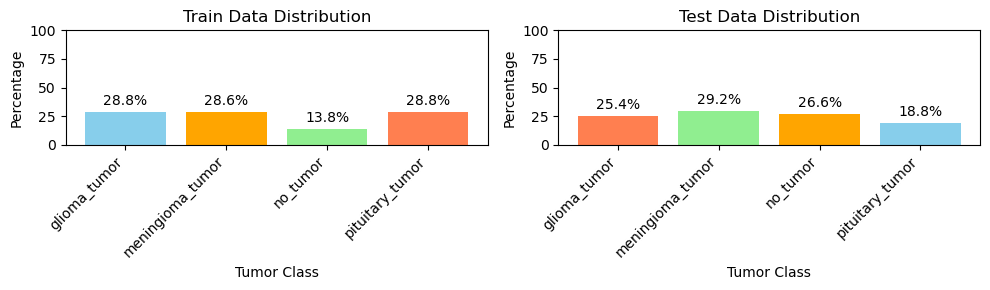

In [31]:
def create_bar_graph(ax, data, title, colors, labels):
    ordered_data = data.reindex(labels)
    bars = ax.bar(ordered_data.index, ordered_data.values, color=colors)
    ax.set(title=title, xlabel='Tumor Class', ylabel='Percentage', ylim=(0, 100))
    ax.set_xticks(range(len(ordered_data.index)))
    ax.set_xticklabels(ordered_data.index, rotation=45, ha='right')
    
    for bar in bars:
        ax.annotate(f'{bar.get_height():.1f}%', 
                    xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
for ax, df, title, colors in zip(axes, [train_df, test_df], 
                                 ['Train Data Distribution', 'Test Data Distribution'], 
                                 [['skyblue', 'orange', 'lightgreen', 'coral'], 
                                  ['coral', 'lightgreen', 'orange', 'skyblue']]):
    label_counts = df['tumor_class'].value_counts(normalize=True, sort=False) * 100
    create_bar_graph(ax, label_counts, title, colors, unique_labels)

plt.tight_layout()
plt.show()


## 4. Splitting Training Data into Training and Validation Sets:

In [15]:
train_df, val_data = train_test_split(train_df, train_size = 0.85, random_state = 42, stratify = train_df.tumor_class)
print(train_df.shape),
print(val_data.shape),
print(test_df.shape)

(2439, 2)
(431, 2)
(394, 2)


## 5. Data Augmentation and Normalization

In [18]:
image_size = 128
batch_size = 64

train_img_gen_kwargs  = dict(
    rescale = 1 / 255, rotation_range = 15, width_shift_range = 0.1, zoom_range = 0.02, shear_range = 0.01,
    brightness_range = [0.3, 1.5],  horizontal_flip = True, vertical_flip = True, fill_mode = "nearest")

test_img_gen_kwargs = dict(rescale = 1 / 255)

## 6. Data Generator

In [19]:
train_datagen = ImageDataGenerator(**train_img_gen_kwargs ) #generating batches of training data with augmentation.
val_datagen = ImageDataGenerator(**test_img_gen_kwargs) #generating batches of validation data without augmentation.
test_datagen = ImageDataGenerator(**test_img_gen_kwargs)#generating batches of test data without augmentation.

train_dfs = train_datagen.flow_from_dataframe(
    train_df,x_col = 'image_filepaths',y_col = 'tumor_class', seed = 42,
    batch_size = batch_size,target_size = (image_size, image_size),color_mode = 'rgb')

val_dfs  = val_datagen.flow_from_dataframe(
    val_data,x_col = 'image_filepaths',y_col = 'tumor_class',seed = 42,
    shuffle=False,batch_size = batch_size,target_size = (image_size, image_size), color_mode = 'rgb')

test_dfs = test_datagen.flow_from_dataframe(
    test_df, x_col = 'image_filepaths', y_col = 'tumor_class', seed = 42,
    shuffle=False, batch_size = batch_size, target_size = (image_size, image_size), color_mode = 'rgb')

Found 2439 validated image filenames belonging to 4 classes.
Found 431 validated image filenames belonging to 4 classes.
Found 394 validated image filenames belonging to 4 classes.


## 7. Model Development

In [20]:
# Define image size
image_size = 128

# Model Definition
def model_def(base_model):
    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze specific layers if necessary
    base_model.layers[-2].trainable = True
    base_model.layers[-3].trainable = True
    base_model.layers[-4].trainable = True

    # Define the new model
    model = Sequential()
    model.add(Input(shape=(image_size, image_size, 3)))
    model.add(base_model)
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))  # Assuming 4 classes in the output
    return model

# Load the base VGG16 model
VGG_model = VGG16(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')

# Create the full model using the model definition
model_vgg = model_def(VGG_model)
model_vgg.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

model_vgg.summary()

# Early Stopping and Model Checkpoint
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=10, restore_best_weights=True)

model_checkpoint = ModelCheckpoint('vgg_model.h5', save_best_only=True, monitor='val_categorical_accuracy',
                                   mode='max', verbose=1, save_weights_only=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15763908 (60.13 MB)
Trainable params: 8128

In [21]:
# Train the model
history_vgg = model_vgg.fit(train_dfs, validation_data=val_dfs, epochs=30, callbacks=[early_stopping,model_checkpoint])

model_vgg.save('vgg_model.h5')

Epoch 1/30
39/39 [==============================] - ETA: 0s - loss: 1.3691 - categorical_accuracy: 0.3657
Epoch 1: val_categorical_accuracy improved from -inf to 0.64037, saving model to vgg_model.h5


C:\Users\bchai\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 360s 9s/step - loss: 1.3691 - categorical_accuracy: 0.3657 - val_loss: 1.0418 - val_categorical_accuracy: 0.6404
Epoch 2/30
39/39 [==============================] - ETA: 0s - loss: 1.1399 - categorical_accuracy: 0.5088
Epoch 2: val_categorical_accuracy did not improve from 0.64037
39/39 [==============================] - 332s 9s/step - loss: 1.1399 - categorical_accuracy: 0.5088 - val_loss: 0.8865 - val_categorical_accuracy: 0.6079
Epoch 3/30
39/39 [==============================] - ETA: 0s - loss: 1.0106 - categorical_accuracy: 0.5679
Epoch 3: val_categorical_accuracy did not improve from 0.64037
39/39 [==============================] - 337s 9s/step - loss: 1.0106 - categorical_accuracy: 0.5679 - val_loss: 0.9132 - val_categorical_accuracy: 0.5800
Epoch 4/30
39/39 [==============================] - ETA: 0s - loss: 0.8362 - categorical_accuracy: 0.6667
Epoch 4: val_categorical_accuracy improved from 0.64037 to 0.73318, saving model to vgg_model.

Epoch 26/30
39/39 [==============================] - ETA: 0s - loss: 0.2285 - categorical_accuracy: 0.9213
Epoch 26: val_categorical_accuracy did not improve from 0.90951
39/39 [==============================] - 340s 9s/step - loss: 0.2285 - categorical_accuracy: 0.9213 - val_loss: 0.3075 - val_categorical_accuracy: 0.8817
Epoch 27/30
39/39 [==============================] - ETA: 0s - loss: 0.2243 - categorical_accuracy: 0.9180
Epoch 27: val_categorical_accuracy improved from 0.90951 to 0.92807, saving model to vgg_model.h5
39/39 [==============================] - 332s 9s/step - loss: 0.2243 - categorical_accuracy: 0.9180 - val_loss: 0.2390 - val_categorical_accuracy: 0.9281
Epoch 28/30
39/39 [==============================] - ETA: 0s - loss: 0.2009 - categorical_accuracy: 0.9258
Epoch 28: val_categorical_accuracy did not improve from 0.92807
39/39 [==============================] - 376s 10s/step - loss: 0.2009 - categorical_accuracy: 0.9258 - val_loss: 0.2472 - val_categorical_accurac

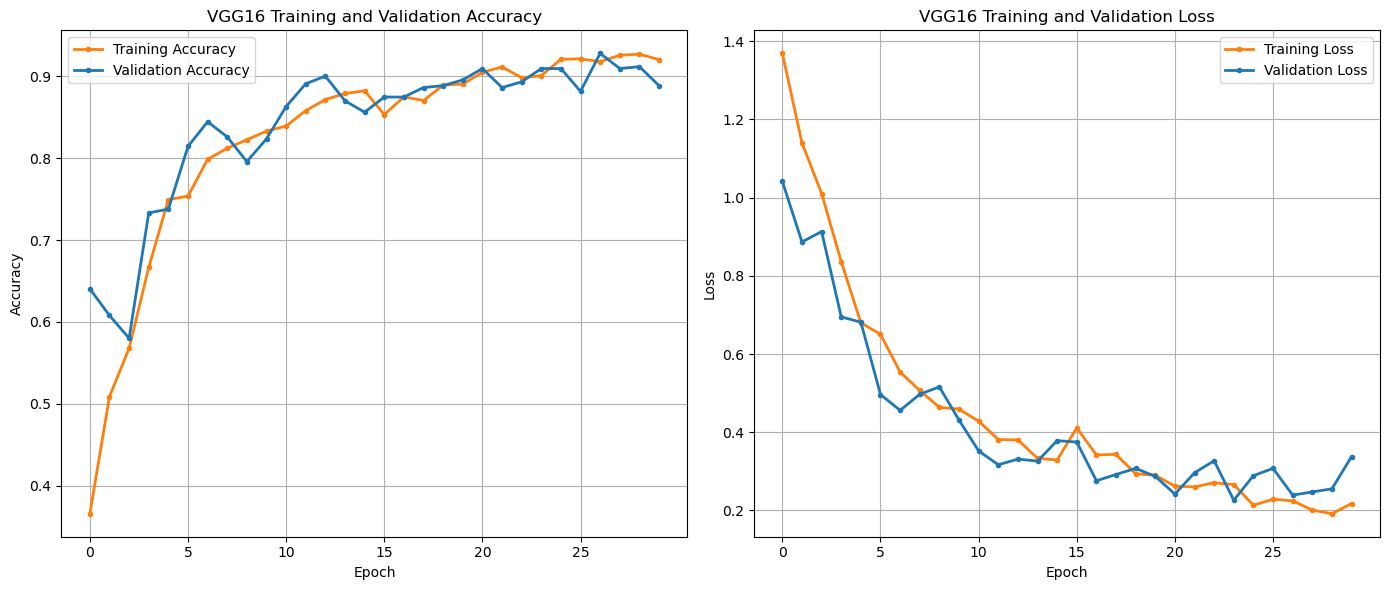

In [22]:
# Plotting the training and validation metrics
plot_training_history(history_vgg, model_name='VGG16')

In [23]:
# Evaluate the model on the test set
evaluation_results_vgg = model_vgg.evaluate(test_dfs)

print(f'Test Loss: {evaluation_results_vgg[0]}')
print(f'Test Accuracy: {evaluation_results_vgg[1]}')

7/7 [==============================] - 39s 5s/step - loss: 2.3425 - categorical_accuracy: 0.7234
Test Loss: 2.342503786087036
Test Accuracy: 0.7233502268791199


In [24]:
# Predictions
y_pred_vgg = model_vgg.predict(test_dfs)
y_pred_labels_vgg = np.argmax(y_pred_vgg, axis=1)

acc = []
# Calculate and print the accuracy
accuracy = accuracy_score(test_dfs.labels, y_pred_labels_vgg)
print(f'Prediction Accuracy: {accuracy * 100:.2f}%')
acc.append(accuracy*100)

7/7 [==============================] - 38s 5s/step
Prediction Accuracy: 72.34%


In [25]:
# classification report
print(classification_report(test_dfs.labels, y_pred_labels_vgg, target_names=unique_labels,zero_division=0))

                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.27      0.42       100
meningioma_tumor       0.68      0.91      0.78       115
        no_tumor       0.69      0.98      0.81       105
 pituitary_tumor       0.82      0.68      0.74        74

        accuracy                           0.72       394
       macro avg       0.79      0.71      0.69       394
    weighted avg       0.78      0.72      0.69       394



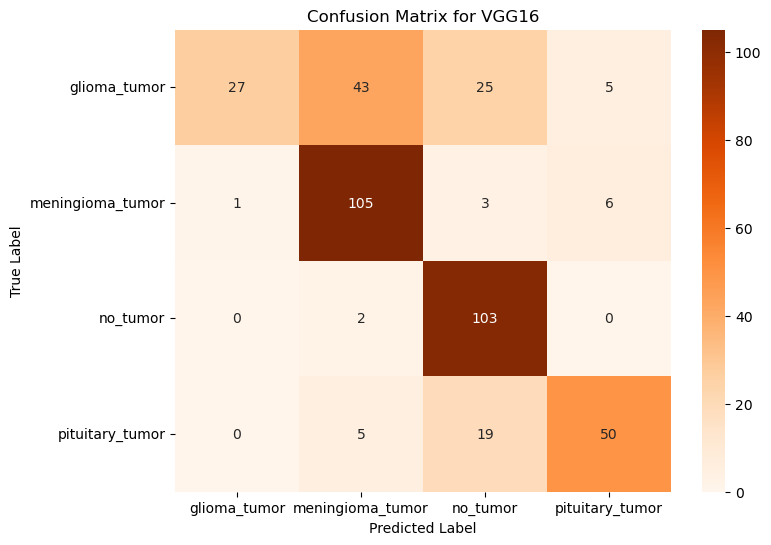

In [26]:
# Plotting the confusion matrix

conf_matrix = confusion_matrix(test_dfs.labels, y_pred_labels_vgg)
conf_matrix_data_vgg = np.array(conf_matrix)
plot_confusion_matrix(test_dfs.labels, y_pred_labels_vgg, unique_labels, model_name='VGG16')

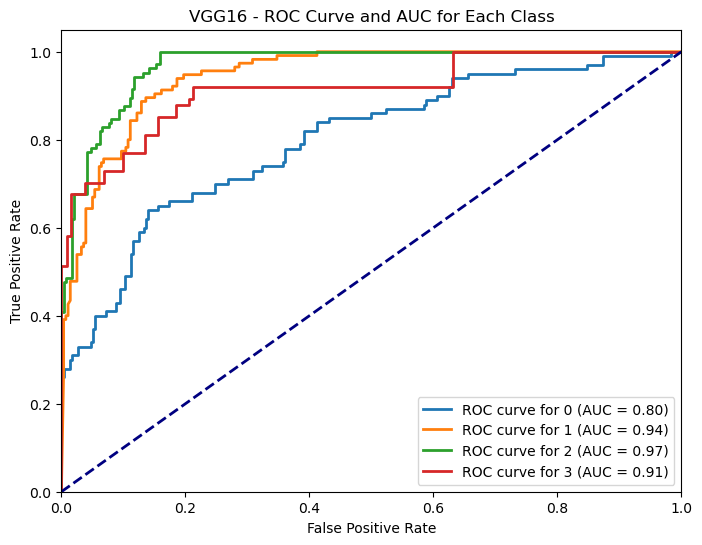

In [27]:
# Compute ROC curve and AUC for each class
plot_multiclass_roc(test_dfs.labels, y_pred_vgg, model_name='VGG16')

1/1 [==============================] - 0s 370ms/step
Actual Class: glioma_tumor
Predicted Class: glioma_tumor with confidence 0.8221


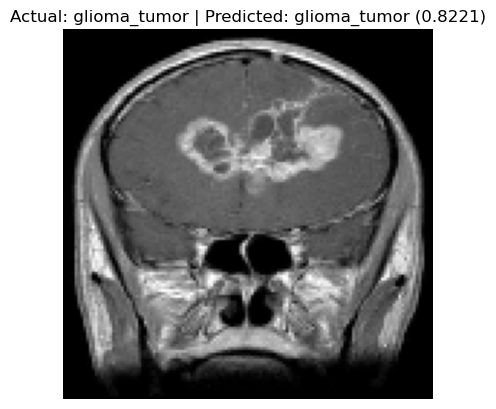

In [31]:
# Testing the Randome images

predicted_label = predict_and_display('vgg_model.h5', 'Testing/glioma_tumor/image(1).jpg', actual_class= 'glioma_tumor')

1/1 [==============================] - 0s 342ms/step
Actual Class: meningioma_tumor
Predicted Class: meningioma_tumor with confidence 0.9914


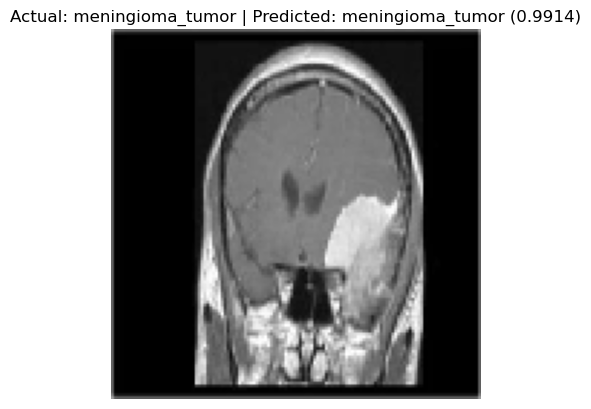

In [32]:
predicted_label = predict_and_display('vgg_model.h5', 'Testing/meningioma_tumor/image(1).jpg', actual_class= 'meningioma_tumor')


1/1 [==============================] - 0s 340ms/step
Actual Class: no_tumor
Predicted Class: no_tumor with confidence 0.8409


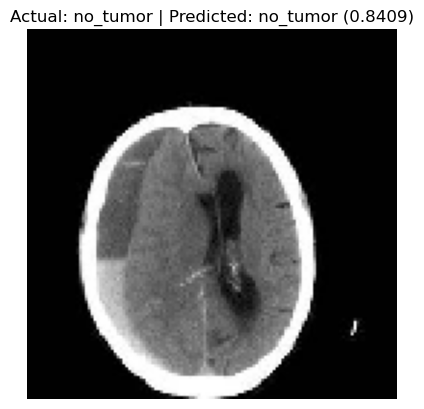

In [33]:
predicted_label = predict_and_display('vgg_model.h5', 'Testing/no_tumor/image(1).jpg', actual_class= 'no_tumor')


1/1 [==============================] - 0s 342ms/step
Actual Class: pituitary_tumor
Predicted Class: pituitary_tumor with confidence 0.9985


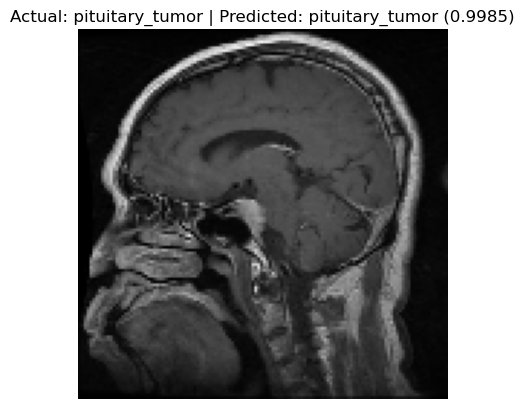

In [34]:
predicted_label = predict_and_display('vgg_model.h5', 'Testing/pituitary_tumor/image(1).jpg', actual_class= 'pituitary_tumor')

### 7.2 Development of Xception model

In [35]:
# Define the model using Xception as the base
model_xception = model_def(Xception(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet'))
model_xception.summary()

# Compile the model
model_xception.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='categorical_crossentropy',
                       metrics=['categorical_accuracy'])

model_checkpoint = ModelCheckpoint('Xception_model.h5', save_best_only=True, monitor='val_categorical_accuracy',
                                   mode='max', verbose=1, save_weights_only=False)

83683744/83683744 [==============================] - 9s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_2 (Dropout)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               4194432   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                       

In [36]:
# Train the model
history_xception = model_xception.fit(train_dfs,
                                      batch_size=batch_size,
                                      validation_data=val_dfs,
                                      epochs=30,
                                      callbacks=[early_stopping, model_checkpoint])

# Save the entire model
model_vgg.save('Xception_model.h5')

Epoch 1/30
39/39 [==============================] - ETA: 0s - loss: 0.8865 - categorical_accuracy: 0.6326
Epoch 1: val_categorical_accuracy improved from -inf to 0.75870, saving model to Xception_model.h5


C:\Users\bchai\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 151s 4s/step - loss: 0.8865 - categorical_accuracy: 0.6326 - val_loss: 0.6181 - val_categorical_accuracy: 0.7587
Epoch 2/30
39/39 [==============================] - ETA: 0s - loss: 0.6161 - categorical_accuracy: 0.7630
Epoch 2: val_categorical_accuracy improved from 0.75870 to 0.80510, saving model to Xception_model.h5
39/39 [==============================] - 141s 4s/step - loss: 0.6161 - categorical_accuracy: 0.7630 - val_loss: 0.4886 - val_categorical_accuracy: 0.8051
Epoch 3/30
39/39 [==============================] - ETA: 0s - loss: 0.5499 - categorical_accuracy: 0.7888
Epoch 3: val_categorical_accuracy improved from 0.80510 to 0.82599, saving model to Xception_model.h5
39/39 [==============================] - 141s 4s/step - loss: 0.5499 - categorical_accuracy: 0.7888 - val_loss: 0.4863 - val_categorical_accuracy: 0.8260
Epoch 4/30
39/39 [==============================] - ETA: 0s - loss: 0.4877 - categorical_accuracy: 0.8155
Epoch 4: val_cat

Epoch 26/30
39/39 [==============================] - ETA: 0s - loss: 0.2038 - categorical_accuracy: 0.9213
Epoch 26: val_categorical_accuracy did not improve from 0.90487
39/39 [==============================] - 140s 4s/step - loss: 0.2038 - categorical_accuracy: 0.9213 - val_loss: 0.3312 - val_categorical_accuracy: 0.8910
Epoch 27/30
39/39 [==============================] - ETA: 0s - loss: 0.1864 - categorical_accuracy: 0.9291
Epoch 27: val_categorical_accuracy did not improve from 0.90487
39/39 [==============================] - 141s 4s/step - loss: 0.1864 - categorical_accuracy: 0.9291 - val_loss: 0.2815 - val_categorical_accuracy: 0.8910


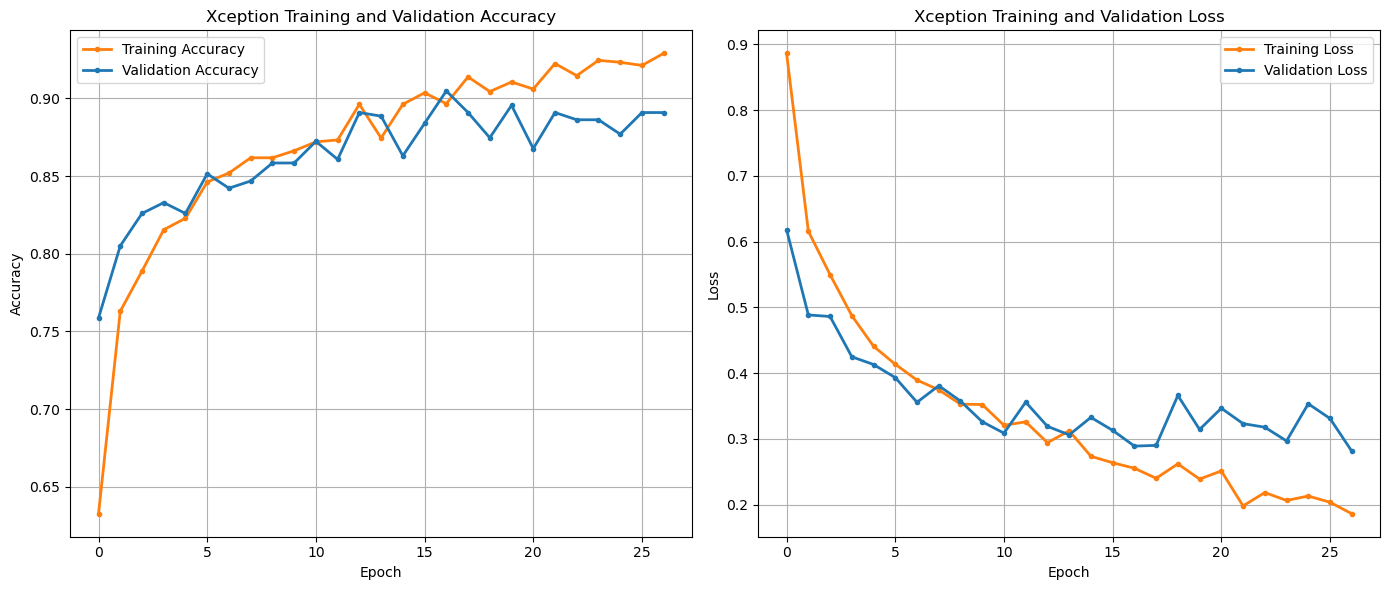

In [37]:
# Plotting the training and validation metrics 
plot_training_history(history_xception, model_name='Xception')

In [38]:
# Evaluate the model on the test set
evaluation_xception = model_xception.evaluate(test_dfs)

print(f'Test Loss: {evaluation_xception[0]}')
print(f'Test Accuracy: {evaluation_xception[1]}')

7/7 [==============================] - 16s 2s/step - loss: 1.4894 - categorical_accuracy: 0.7310
Test Loss: 1.4894187450408936
Test Accuracy: 0.7309644818305969


In [39]:
# Predictions and Confusion Matrix
y_pred_xception = model_xception.predict(test_dfs)
y_pred_labels_xception = np.argmax(y_pred_xception, axis=1)

# Calculate and print the accuracy
accuracy = accuracy_score(test_dfs.labels, y_pred_labels_xception)
print(f'Prediction Accuracy: {accuracy * 100:.2f}%')

acc.append(accuracy*100)

7/7 [==============================] - 16s 2s/step
Prediction Accuracy: 73.10%


In [40]:
# classification report
print(classification_report(test_dfs.labels, np.argmax(y_pred_xception, axis=1), target_names=unique_labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.79      0.33      0.46       100
meningioma_tumor       0.63      0.85      0.73       115
        no_tumor       0.80      0.93      0.86       105
 pituitary_tumor       0.80      0.80      0.80        74

        accuracy                           0.73       394
       macro avg       0.75      0.73      0.71       394
    weighted avg       0.75      0.73      0.71       394



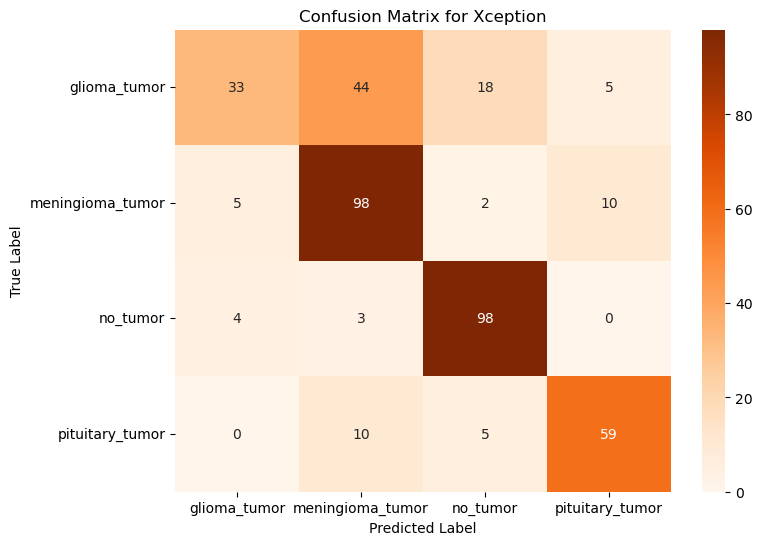

In [41]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_dfs.labels, y_pred_labels_xception)
conf_matrix_data_xception = np.array(conf_matrix)

plot_confusion_matrix(test_dfs.labels, y_pred_labels_xception, unique_labels, model_name='Xception')

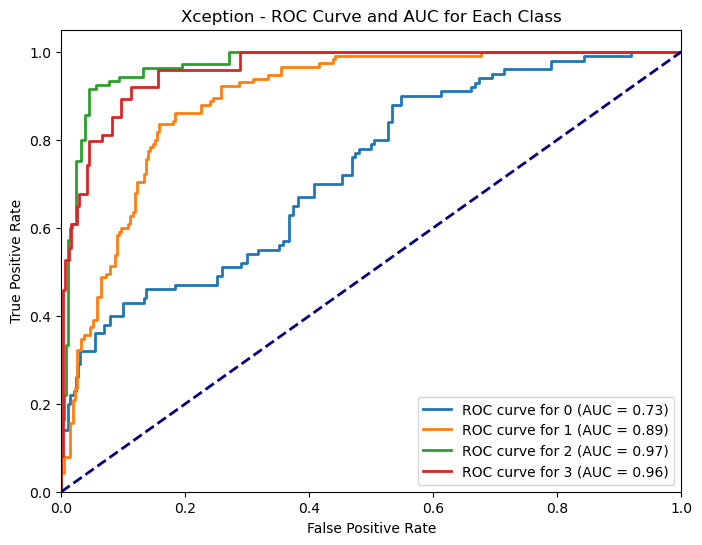

In [42]:
# Compute ROC curve and AUC for each class
plot_multiclass_roc(test_dfs.labels, y_pred_xception, model_name='Xception')

1/1 [==============================] - 0s 341ms/step
Actual Class: glioma_tumor
Predicted Class: glioma_tumor with confidence 1.0000


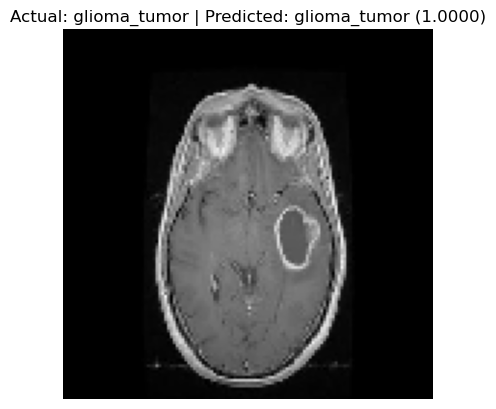

In [48]:
# Testing the Image
predicted_label = predict_and_display('Xception_model.h5', 'Testing/glioma_tumor/image(4).jpg', actual_class='glioma_tumor')


1/1 [==============================] - 0s 359ms/step
Actual Class: meningioma_tumor
Predicted Class: meningioma_tumor with confidence 0.9138


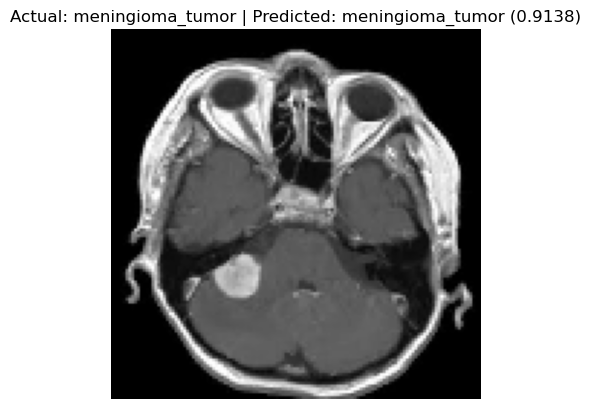

In [49]:
predicted_label = predict_and_display('Xception_model.h5', 'Testing/meningioma_tumor/image(4).jpg', actual_class='meningioma_tumor')


1/1 [==============================] - 0s 360ms/step
Actual Class: no_tumor
Predicted Class: no_tumor with confidence 0.9932


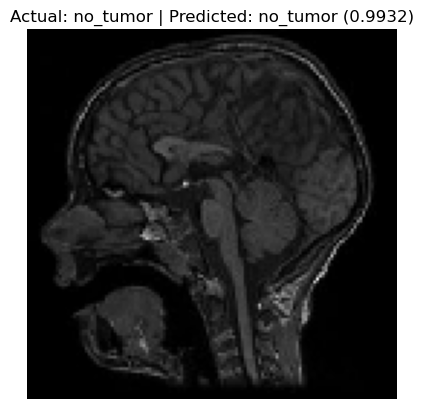

In [50]:
predicted_label = predict_and_display('Xception_model.h5', 'Testing/no_tumor/image(4).jpg', actual_class='no_tumor')


1/1 [==============================] - 0s 341ms/step
Actual Class: pituitary_tumor
Predicted Class: pituitary_tumor with confidence 0.9985


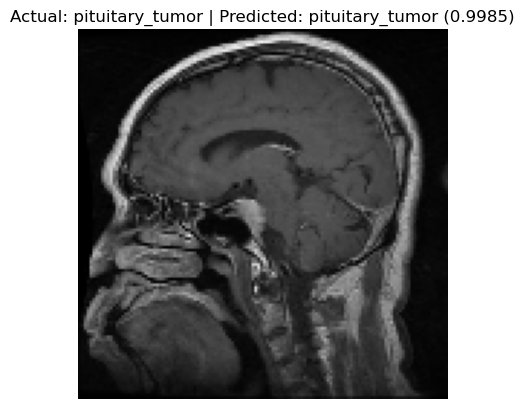

In [52]:
predicted_label = predict_and_display('Xception_model.h5','Testing/pituitary_tumor/image(2).jpg',actual_class='pituitary_tumor')

## 8.3 Development of MobileNet

In [54]:
# Define the model using MobileNet as the base
model_MobileNet = model_def(MobileNet(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet'))
model_MobileNet.summary()

# Compile the model
model_MobileNet.compile(optimizer=Adam(learning_rate=0.00001),
                        loss='categorical_crossentropy',
                        metrics=['categorical_accuracy'])

# Save the entire model 
model_checkpoint = ModelCheckpoint('MobileNet.h5', save_best_only=True, monitor='val_categorical_accuracy',
                                   mode='max', verbose=1, save_weights_only=False)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten_3 (Flatten)         (None, 16384)             0         
                                                                 
 dropout_6 (Dropout)         (None, 16384)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               2097280   
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                      

In [55]:
# Train the model
history_MobileNet = model_MobileNet.fit(
    train_dfs, batch_size=batch_size, validation_data=val_dfs,
    epochs=50, callbacks=[early_stopping,model_checkpoint])

# Save the entire model 
model_vgg.save('MobileNet_model.h5')

Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 2.0955 - categorical_accuracy: 0.3571
Epoch 1: val_categorical_accuracy improved from -inf to 0.52900, saving model to MobileNet.h5


C:\Users\bchai\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 50s 1s/step - loss: 2.0955 - categorical_accuracy: 0.3571 - val_loss: 1.1932 - val_categorical_accuracy: 0.5290
Epoch 2/50
39/39 [==============================] - ETA: 0s - loss: 1.4485 - categorical_accuracy: 0.4969
Epoch 2: val_categorical_accuracy improved from 0.52900 to 0.65661, saving model to MobileNet.h5
39/39 [==============================] - 44s 1s/step - loss: 1.4485 - categorical_accuracy: 0.4969 - val_loss: 0.8993 - val_categorical_accuracy: 0.6566
Epoch 3/50
39/39 [==============================] - ETA: 0s - loss: 1.2043 - categorical_accuracy: 0.5715
Epoch 3: val_categorical_accuracy improved from 0.65661 to 0.70766, saving model to MobileNet.h5
39/39 [==============================] - 66s 2s/step - loss: 1.2043 - categorical_accuracy: 0.5715 - val_loss: 0.7545 - val_categorical_accuracy: 0.7077
Epoch 4/50
39/39 [==============================] - ETA: 0s - loss: 1.0205 - categorical_accuracy: 0.6171
Epoch 4: val_categorical_accu

Epoch 26/50
39/39 [==============================] - ETA: 0s - loss: 0.4380 - categorical_accuracy: 0.8401
Epoch 26: val_categorical_accuracy did not improve from 0.85151
39/39 [==============================] - 45s 1s/step - loss: 0.4380 - categorical_accuracy: 0.8401 - val_loss: 0.3594 - val_categorical_accuracy: 0.8492
Epoch 27/50
39/39 [==============================] - ETA: 0s - loss: 0.4514 - categorical_accuracy: 0.8257
Epoch 27: val_categorical_accuracy did not improve from 0.85151
39/39 [==============================] - 46s 1s/step - loss: 0.4514 - categorical_accuracy: 0.8257 - val_loss: 0.3566 - val_categorical_accuracy: 0.8469
Epoch 28/50
39/39 [==============================] - ETA: 0s - loss: 0.4416 - categorical_accuracy: 0.8266
Epoch 28: val_categorical_accuracy improved from 0.85151 to 0.86775, saving model to MobileNet.h5
39/39 [==============================] - 44s 1s/step - loss: 0.4416 - categorical_accuracy: 0.8266 - val_loss: 0.3372 - val_categorical_accuracy: 0


39/39 [==============================] - 45s 1s/step - loss: 0.3073 - categorical_accuracy: 0.8799 - val_loss: 0.2672 - val_categorical_accuracy: 0.8933


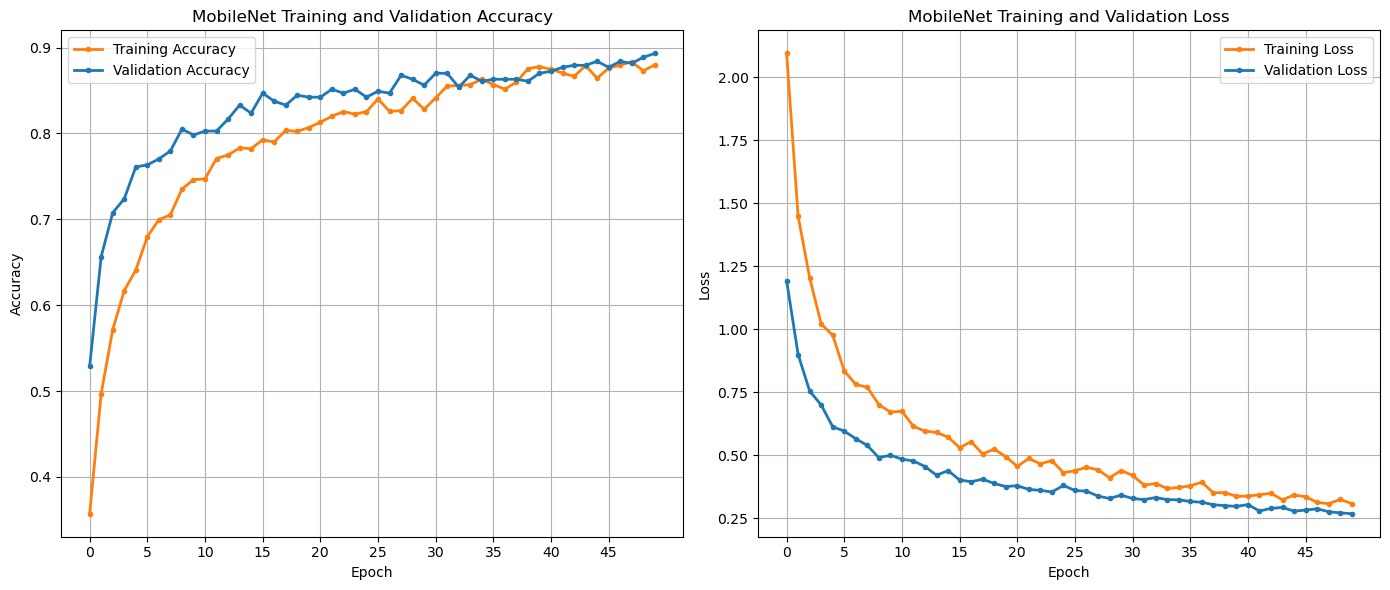

In [56]:
# Plotting the training and validation metrics
plot_training_history(history_MobileNet, model_name='MobileNet')

In [57]:
# Evaluate the model on the test set
evaluation_MobileNet = model_MobileNet.evaluate(test_dfs)

print(f'Test Loss: {evaluation_MobileNet[0]}')
print(f'Test Accuracy: {evaluation_MobileNet[1]}')

7/7 [==============================] - 6s 849ms/step - loss: 1.4034 - categorical_accuracy: 0.6574
Test Loss: 1.4034045934677124
Test Accuracy: 0.6573604345321655


In [58]:
# Predictions and Confusion Matrix
y_pred_MobileNet = model_MobileNet.predict(test_dfs)
y_pred_labels_MobileNet = np.argmax(y_pred_MobileNet, axis=1)

# Calculate and print the accuracy
accuracy = accuracy_score(test_dfs.labels, y_pred_labels_MobileNet)
print(f'Prediction Accuracy: {accuracy * 100:.2f}%')

acc.append(accuracy*100)

7/7 [==============================] - 4s 500ms/step
Prediction Accuracy: 65.74%


In [59]:
# classification report
print(classification_report(test_dfs.labels, np.argmax(y_pred_MobileNet, axis=1), target_names=unique_labels))

                  precision    recall  f1-score   support

    glioma_tumor       0.68      0.21      0.32       100
meningioma_tumor       0.66      0.75      0.70       115
        no_tumor       0.63      0.93      0.75       105
 pituitary_tumor       0.71      0.73      0.72        74

        accuracy                           0.66       394
       macro avg       0.67      0.66      0.62       394
    weighted avg       0.66      0.66      0.62       394



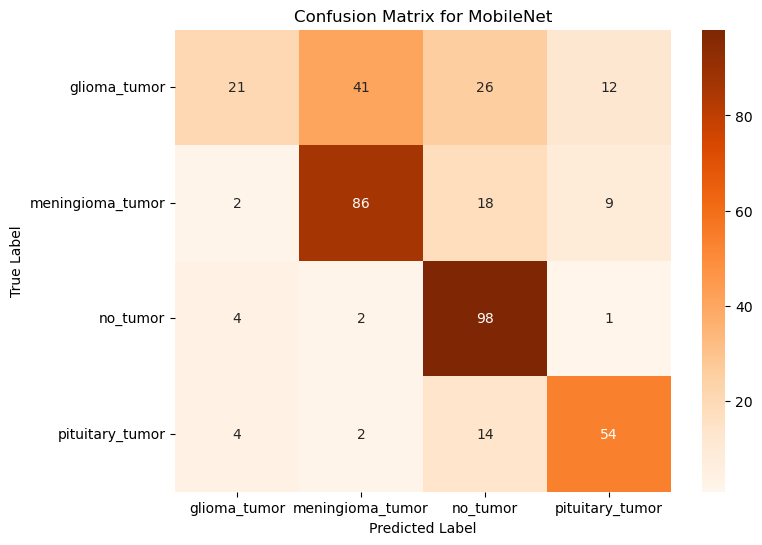

In [60]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_dfs.labels, y_pred_labels_MobileNet)
conf_matrix_data_MobileNet = np.array(conf_matrix)


plot_confusion_matrix(test_dfs.labels, y_pred_labels_MobileNet, unique_labels, model_name='MobileNet')

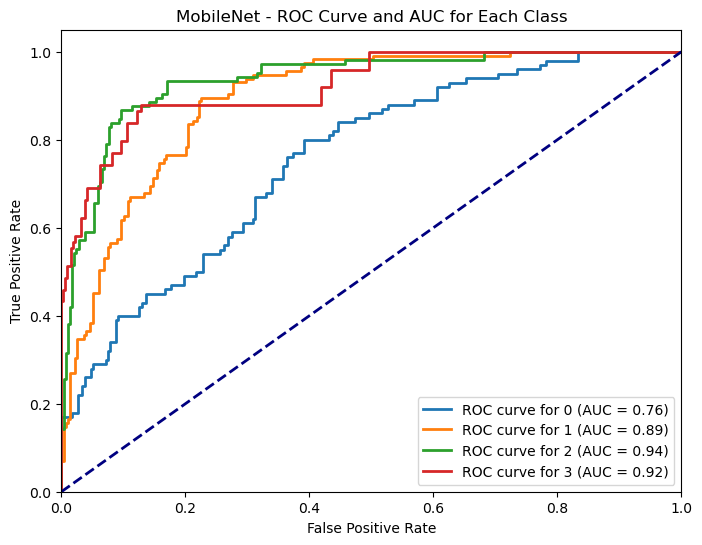

In [61]:
# Compute ROC curve and AUC for each class
plot_multiclass_roc(test_dfs.labels, y_pred_MobileNet, model_name='MobileNet')

1/1 [==============================] - 0s 356ms/step
Actual Class: glioma_tumor
Predicted Class: meningioma_tumor with confidence 0.8246


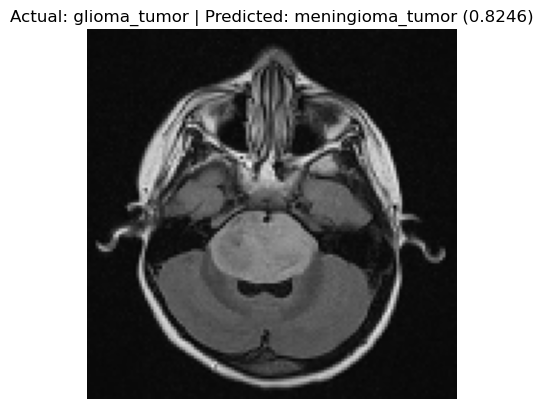

In [62]:
# Testing
predicted_label = predict_and_display('MobileNet_model.h5', 'Testing/glioma_tumor/image(2).jpg',actual_class='glioma_tumor')

1/1 [==============================] - 0s 374ms/step
Actual Class: meningioma_tumor
Predicted Class: meningioma_tumor with confidence 1.0000


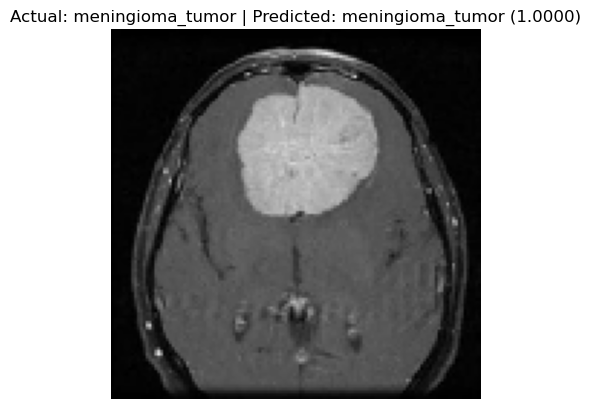

In [65]:
predicted_label = predict_and_display('MobileNet_model.h5', 'Testing/meningioma_tumor/image(2).jpg',actual_class='meningioma_tumor')

1/1 [==============================] - 0s 361ms/step
Actual Class: no_tumor
Predicted Class: no_tumor with confidence 0.9980


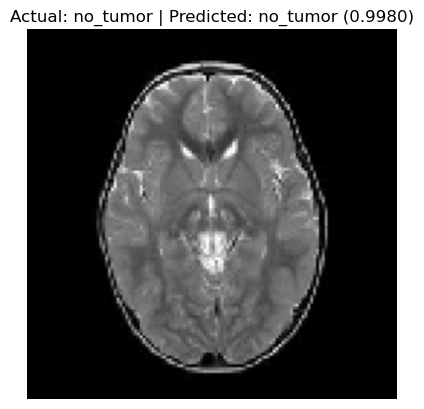

In [66]:
predicted_label = predict_and_display('MobileNet_model.h5', 'Testing/no_tumor/image(2).jpg',actual_class='no_tumor')

1/1 [==============================] - 0s 352ms/step
Actual Class: pituitary_tumor
Predicted Class: pituitary_tumor with confidence 0.9985


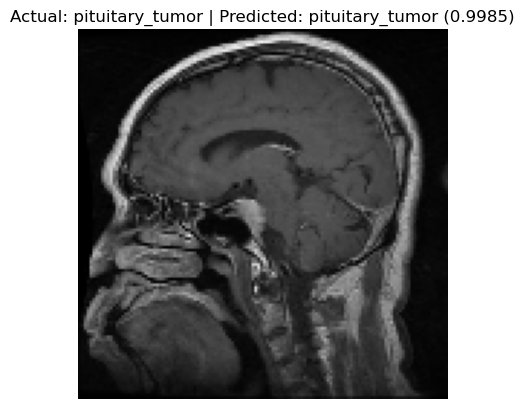

In [67]:
predicted_label = predict_and_display('MobileNet_model.h5', 'Testing/pituitary_tumor/image(1).jpg',actual_class='pituitary_tumor')

# 7.4 Development of ReseNet50

In [68]:
# Define the model using ResNet50 as the base
model_ResNet50 = model_def(ResNet50(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet'))
model_ResNet50.summary()

# Compile the model
model_ResNet50.compile(optimizer=Adam(learning_rate=0.00005),
                       loss='categorical_crossentropy',
                       metrics=['categorical_accuracy'])

# Save the entire model
model_checkpoint = ModelCheckpoint('ResNet50.h5', save_best_only=True, monitor='val_categorical_accuracy',
                                   mode='max', verbose=1, save_weights_only=False)

94765736/94765736 [==============================] - 10s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_8 (Dropout)         (None, 32768)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               4194432   
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 516       
                                                      

In [69]:
# Train the model
history_ResNet50 = model_ResNet50.fit(
    train_dfs, batch_size=batch_size, validation_data=val_dfs,
    epochs=50, callbacks=[early_stopping,model_checkpoint])

# Save the entire model 
model_vgg.save('ResNet50_model.h5')

Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 1.3207 - categorical_accuracy: 0.3727
Epoch 1: val_categorical_accuracy improved from -inf to 0.30394, saving model to ResNet50.h5


C:\Users\bchai\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 125s 3s/step - loss: 1.3207 - categorical_accuracy: 0.3727 - val_loss: 1.3487 - val_categorical_accuracy: 0.3039
Epoch 2/50
39/39 [==============================] - ETA: 0s - loss: 1.2102 - categorical_accuracy: 0.4518
Epoch 2: val_categorical_accuracy improved from 0.30394 to 0.32483, saving model to ResNet50.h5
39/39 [==============================] - 115s 3s/step - loss: 1.2102 - categorical_accuracy: 0.4518 - val_loss: 1.3398 - val_categorical_accuracy: 0.3248
Epoch 3/50
39/39 [==============================] - ETA: 0s - loss: 1.1324 - categorical_accuracy: 0.4887
Epoch 3: val_categorical_accuracy did not improve from 0.32483
39/39 [==============================] - 114s 3s/step - loss: 1.1324 - categorical_accuracy: 0.4887 - val_loss: 1.3313 - val_categorical_accuracy: 0.2900
Epoch 4/50
39/39 [==============================] - ETA: 0s - loss: 1.1075 - categorical_accuracy: 0.5129
Epoch 4: val_categorical_accuracy did not improve from 0.3248

Epoch 26/50
39/39 [==============================] - ETA: 0s - loss: 0.8736 - categorical_accuracy: 0.6216
Epoch 26: val_categorical_accuracy did not improve from 0.71926
39/39 [==============================] - 117s 3s/step - loss: 0.8736 - categorical_accuracy: 0.6216 - val_loss: 0.6665 - val_categorical_accuracy: 0.7077
Epoch 27/50
39/39 [==============================] - ETA: 0s - loss: 0.9098 - categorical_accuracy: 0.5953
Epoch 27: val_categorical_accuracy did not improve from 0.71926
39/39 [==============================] - 115s 3s/step - loss: 0.9098 - categorical_accuracy: 0.5953 - val_loss: 0.6780 - val_categorical_accuracy: 0.6613
Epoch 28/50
39/39 [==============================] - ETA: 0s - loss: 0.8823 - categorical_accuracy: 0.6097
Epoch 28: val_categorical_accuracy did not improve from 0.71926
39/39 [==============================] - 115s 3s/step - loss: 0.8823 - categorical_accuracy: 0.6097 - val_loss: 0.6888 - val_categorical_accuracy: 0.6984
Epoch 29/50
39/39 [======

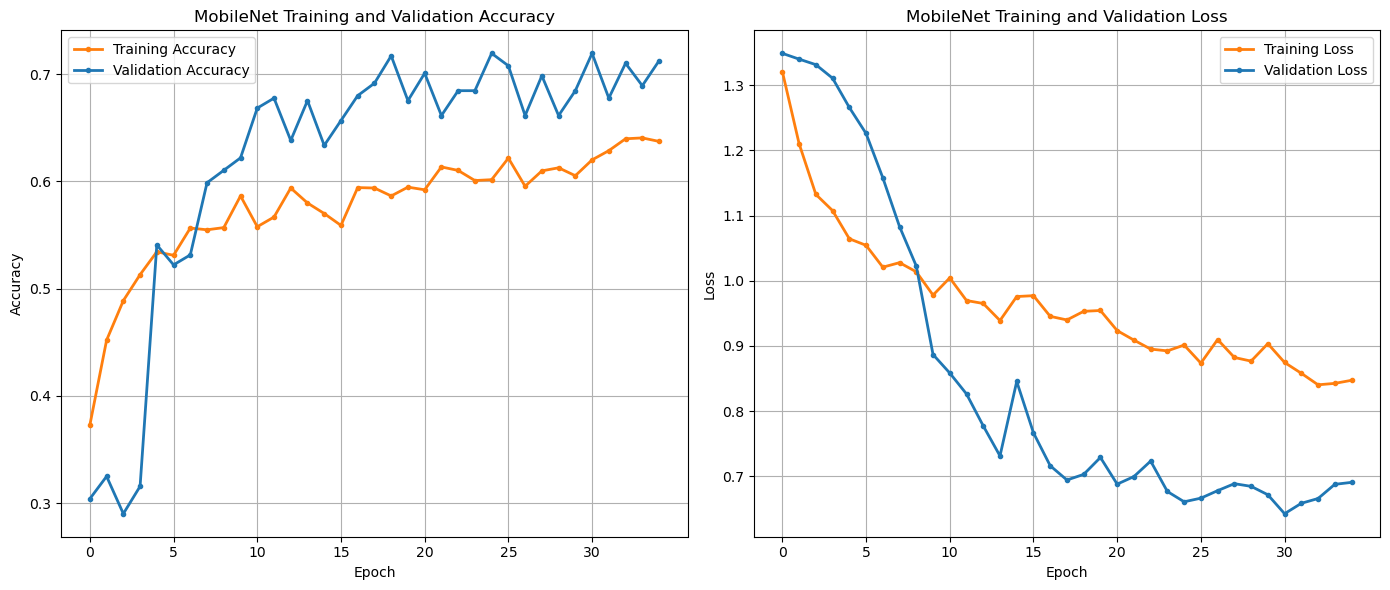

In [71]:
# Plotting the training and validation metrics
plot_training_history(history_ResNet50, model_name='MobileNet')

In [72]:
# Evaluate the model on the test set
evaluation_ResNet50 = model_ResNet50.evaluate(test_dfs)

print(f'Test Loss: {evaluation_ResNet50[0]}')
print(f'Test Accuracy: {evaluation_ResNet50[1]}')

7/7 [==============================] - 15s 2s/step - loss: 1.8643 - categorical_accuracy: 0.4340
Test Loss: 1.8643200397491455
Test Accuracy: 0.4340101480484009


In [73]:
# Predictions and Confusion Matrix
y_pred_ResNet50 = model_ResNet50.predict(test_dfs)
y_pred_labels_ResNet50 = np.argmax(y_pred_ResNet50, axis=1)

# Calculate and print the accuracy
accuracy = accuracy_score(test_dfs.labels, y_pred_labels_ResNet50)
print(f'Prediction Accuracy: {accuracy * 100:.2f}%')

acc.append(accuracy*100)

7/7 [==============================] - 15s 2s/step
Prediction Accuracy: 43.40%


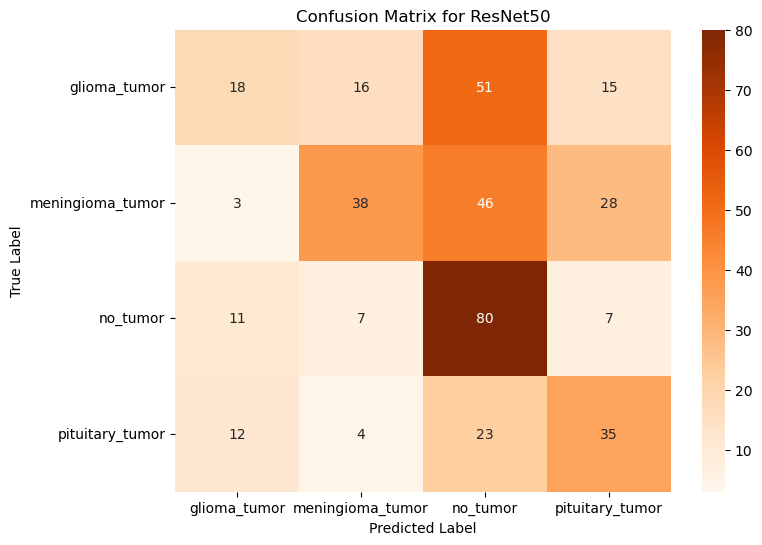

In [74]:
# Plotting the confusion matrix
conf_matrix = confusion_matrix(test_dfs.labels, y_pred_labels_ResNet50)
conf_matrix_data_ReseNet50 = np.array(conf_matrix)

plot_confusion_matrix(test_dfs.labels, y_pred_labels_ResNet50, unique_labels, model_name='ResNet50')

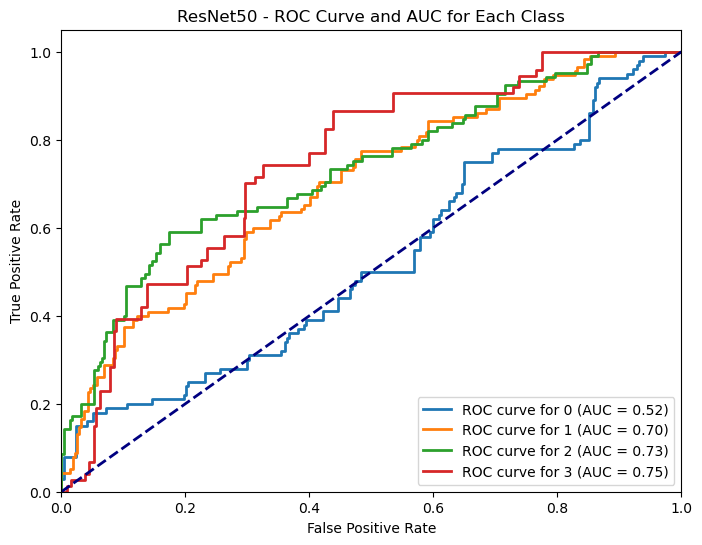

In [75]:
plot_multiclass_roc(test_dfs.labels, y_pred_ResNet50, model_name='ResNet50')

1/1 [==============================] - 0s 386ms/step
Actual Class: glioma_tumor
Predicted Class: glioma_tumor with confidence 0.9855


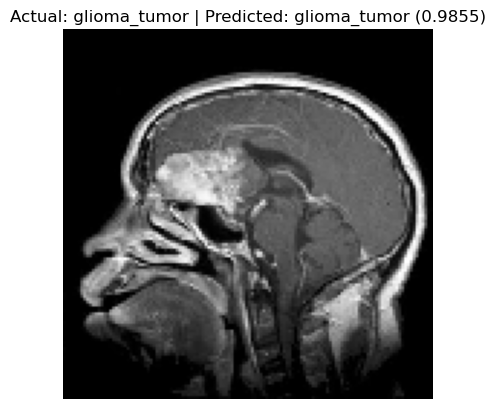

In [84]:
# Testing
predicted_label = predict_and_display('ResNet50_model.h5', 'Testing/glioma_tumor/image(10).jpg',actual_class='glioma_tumor')

1/1 [==============================] - 0s 367ms/step
Actual Class: meningioma_tumor
Predicted Class: meningioma_tumor with confidence 1.0000


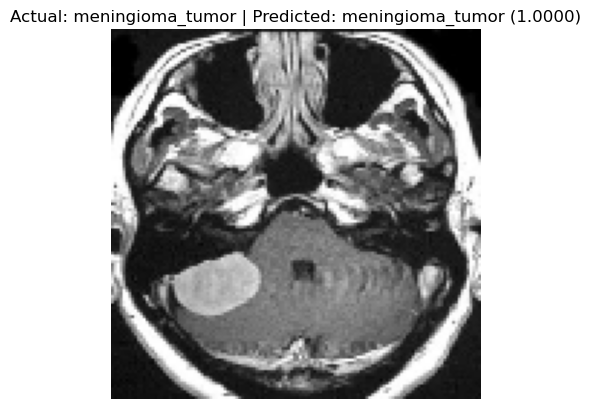

In [83]:
predicted_label = predict_and_display('ResNet50_model.h5', 'Testing/meningioma_tumor/image(6).jpg',actual_class='meningioma_tumor')

1/1 [==============================] - 0s 366ms/step
Actual Class: no_tumor
Predicted Class: no_tumor with confidence 0.9980


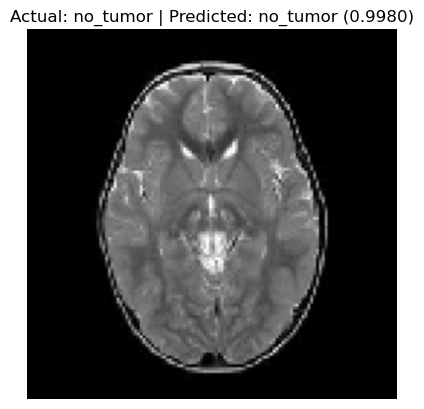

In [80]:
predicted_label = predict_and_display('ResNet50_model.h5', 'Testing/no_tumor/image(2).jpg',actual_class='no_tumor')

1/1 [==============================] - 0s 368ms/step
Actual Class: pituitary_tumor
Predicted Class: pituitary_tumor with confidence 0.9985


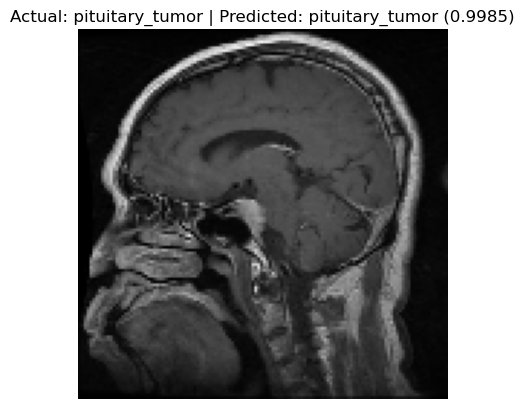

In [82]:
predicted_label = predict_and_display('ResNet50_model.h5', 'Testing/pituitary_tumor/image(3).jpg',actual_class='pituitary_tumor')

## Model Analysis and Comparison

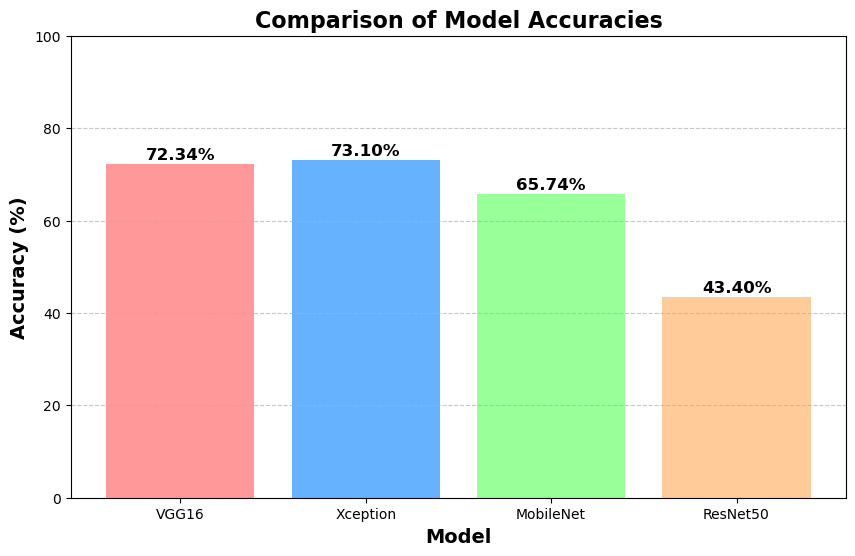

In [85]:
models = ['VGG16', 'Xception', 'MobileNet', 'ResNet50']
df = pd.DataFrame({'Model': models, 'Accuracy': acc})
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']

plt.figure(figsize=(10, 6))
bars = plt.bar(df['Model'], np.array(df['Accuracy']), color=colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', fontsize=12, weight='bold')

plt.xlabel('Model', fontsize=14, weight='bold')
plt.ylabel('Accuracy (%)', fontsize=14, weight='bold')
plt.title('Comparison of Model Accuracies', fontsize=16, weight='bold')
plt.ylim(0, 100)  
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

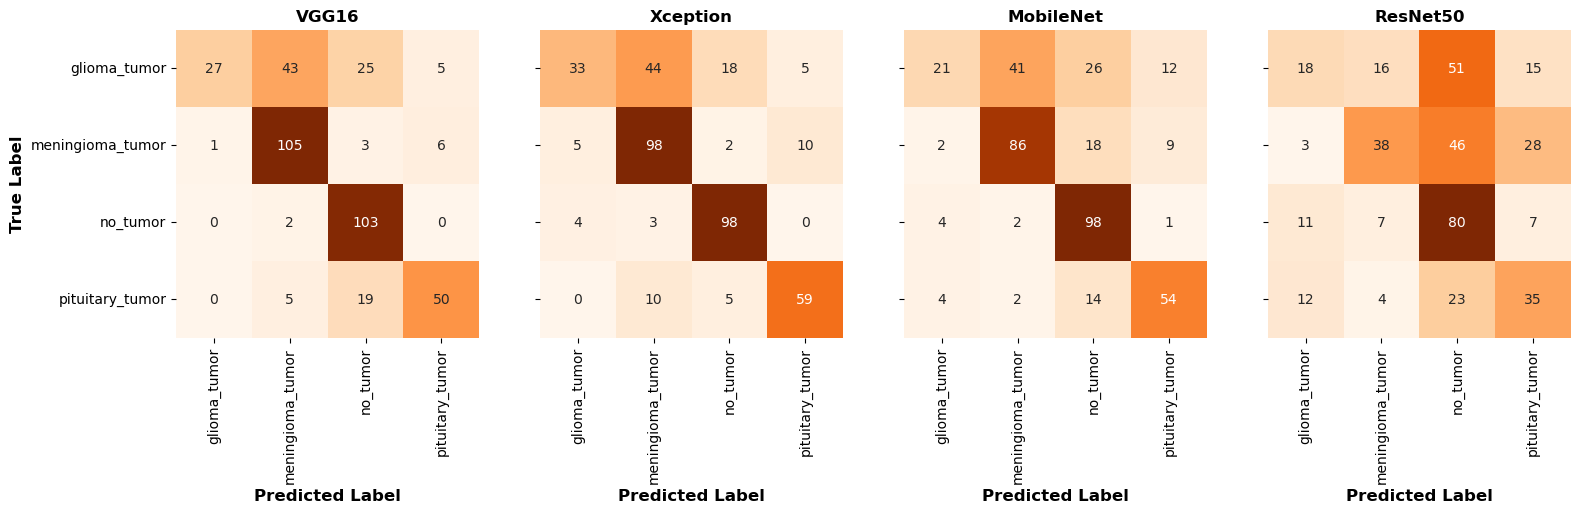

In [86]:
def plot_confusion_matrices(model_data, unique_labels, figsize=(18, 4)):
    fig, axes = plt.subplots(1, len(model_data), figsize=figsize, sharey=True)

    for i, (conf_matrix, model_name) in enumerate(model_data):
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', cbar=False,
                    xticklabels=unique_labels, yticklabels=unique_labels, ax=axes[i])
        axes[i].set_xlabel('Predicted Label', weight='bold', fontsize=12)
        if i == 0:  # Only the first plot has the y-axis label
            axes[i].set_ylabel('True Label', weight='bold', fontsize=12)
        axes[i].set_title(model_name, weight='bold', fontsize=12)

    plt.show()

model_data = [
    (conf_matrix_data_vgg, 'VGG16'),
    (conf_matrix_data_xception, 'Xception'),
    (conf_matrix_data_MobileNet, 'MobileNet'),
    (conf_matrix_data_ReseNet50, 'ResNet50')
]

plot_confusion_matrices(model_data, unique_labels)

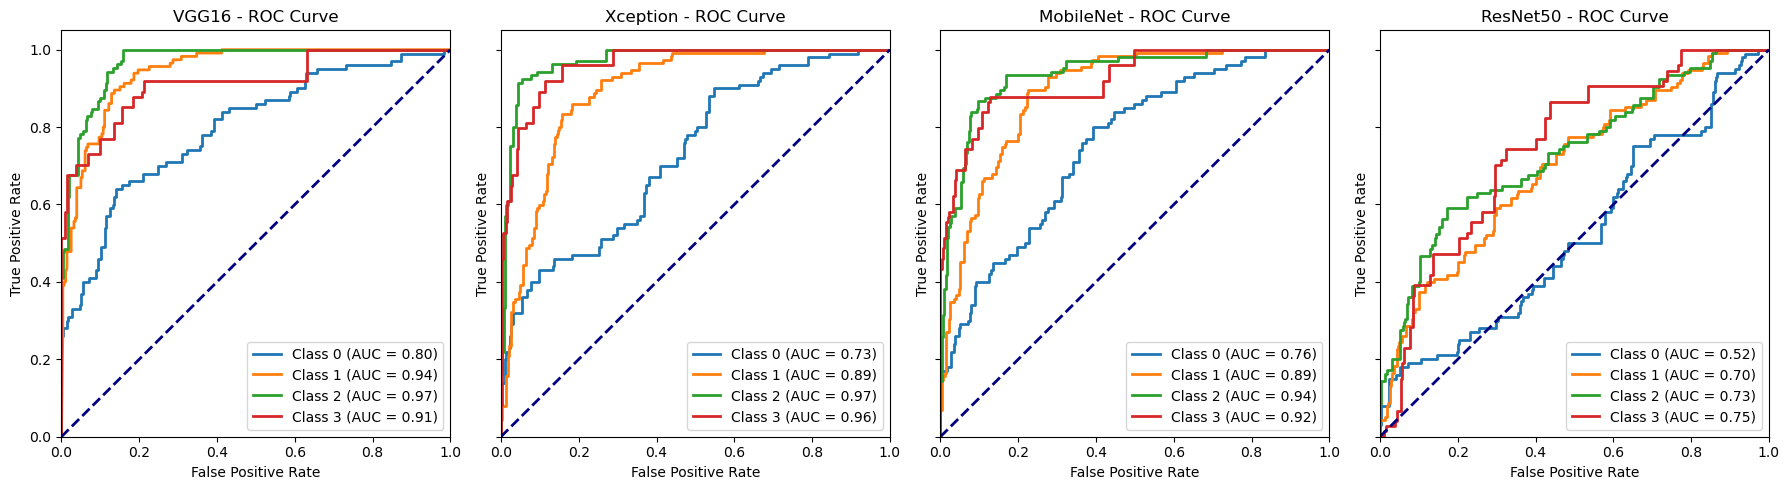

In [87]:
def plot_multiclass_roc_curves_single(models, y_true, y_scores, classes, figsize=(18, 5)):
    # Binarize the true labels
    y_true_bin = label_binarize(y_true, classes=classes)
    n_classes = y_true_bin.shape[1]

    # Create a subplot for each model
    fig, axes = plt.subplots(1, len(models), figsize=figsize, sharey=True)

    for model_idx, (model_name, y_score) in enumerate(zip(models, y_scores)):
        fpr = {}
        tpr = {}
        roc_auc = {}

        for class_idx in range(n_classes):
            fpr[class_idx], tpr[class_idx], _ = roc_curve(y_true_bin[:, class_idx], y_score[:, class_idx])
            roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx])

            ax = axes[model_idx] if len(models) > 1 else axes
            ax.plot(fpr[class_idx], tpr[class_idx], lw=2,
                    label=f'Class {classes[class_idx]} (AUC = {roc_auc[class_idx]:.2f})')

        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate', fontsize=10)
        ax.set_ylabel('True Positive Rate', fontsize=10)
        ax.set_title(f'{model_name} - ROC Curve', fontsize=12)
        ax.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

y_scores = [y_pred_vgg, y_pred_xception, y_pred_MobileNet, y_pred_ResNet50]
classes = [0, 1, 2, 3]
y_true = test_dfs.labels

plot_multiclass_roc_curves_single(models, y_true, y_scores, classes)
